Backtesting
-------




Backtrader --
Zipline --
Backtesting.py

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [14]:
tickers = ['CDNS', 'SNPS']
data = yf.download(tickers, start='2023-01-01', end='2025-01-01')['Close']
data.dropna(inplace=True)

initial_scale = data['CDNS'].iloc[0] / data['SNPS'].iloc[0]
data['SNPS_Scaled'] = data['SNPS'] * initial_scale
data['Spread'] = ((data['CDNS'] - data['SNPS_Scaled']) / (data['CDNS'] + data['SNPS_Scaled'])) * 100

spread=((data['CDNS'] - data['SNPS_Scaled']) / (data['CDNS'] + data['SNPS_Scaled'])) * 100
data.head(3)

[*********************100%***********************]  2 of 2 completed


Ticker,CDNS,SNPS,SNPS_Scaled,Spread
Date,,,,
2023-01-03,159.639999,319.679993,159.639999,0.000000
2023-01-04,159.229996,320.929993,160.264217,-0.323706
2023-01-05,156.800003,315.040009,157.322910,-0.166466


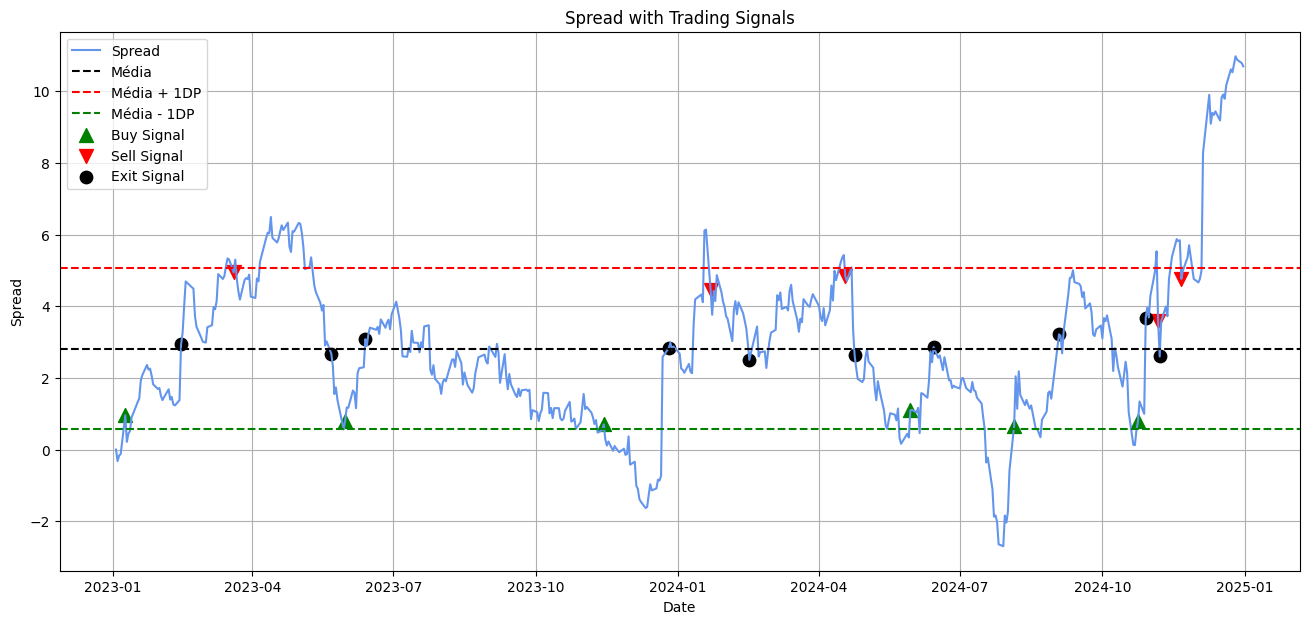

In [15]:
mean_spread = spread.mean()  
std_spread = spread.std()  

upper_band = mean_spread + std_spread
lower_band = mean_spread - std_spread

# Signals
signals = pd.DataFrame(index=spread.index)
signals['spread'] = spread
signals['long'] = False #LONG SIGNAL (Long CDNS, Short SNPS)
signals['short'] = False ## SHORT SIGNAL (Short CDNS, Long SNPS)
signals['exit'] = False
position = 0  # 0 = no position, 1 = Long, -1 = Short

for i in range(1, len(spread)):
    if position == 0:  # no position
        if spread.iloc[i-1] < lower_band and spread.iloc[i] >= lower_band:
            signals.at[spread.index[i], 'long'] = True
            position = 1  # long
        elif spread.iloc[i-1] > upper_band and spread.iloc[i] <= upper_band:
            signals.at[spread.index[i], 'short'] = True
            position = -1  # short
    
    elif position == 1:  # if long, close position in mean
        if spread.iloc[i-1] < mean_spread and spread.iloc[i] >= mean_spread:
            signals.at[spread.index[i], 'exit'] = True
            position = 0  # close position

    elif position == -1:  # if short, close position in mean
        if spread.iloc[i-1] > mean_spread and spread.iloc[i] <= mean_spread:
            signals.at[spread.index[i], 'exit'] = True
            position = 0  # close position
# Plotar os resultados
plt.figure(figsize=(16, 7))
plt.plot(spread, label="Spread", color="cornflowerblue")
plt.axhline(mean_spread, color="black", linestyle="dashed", label="Média")
plt.axhline(upper_band, color="red", linestyle="dashed", label="Média + 1DP")
plt.axhline(lower_band, color="green", linestyle="dashed", label="Média - 1DP")

# signals in the plot
plt.scatter(signals.index[signals['long']], signals['spread'][signals['long']], 
            marker="^", color="green", label="Buy Signal", s=100)
plt.scatter(signals.index[signals['short']], signals['spread'][signals['short']], 
            marker="v", color="red", label="Sell Signal", s=100)
plt.scatter(signals.index[signals['exit']], signals['spread'][signals['exit']], 
            marker="o", color="black", label="Exit Signal", s=80)

plt.legend()
plt.title("Spread with Trading Signals")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.grid(True)
plt.show()


In [16]:
# Backtesting Simulation

# we need to buy/sell 1 units of CDNS (70$) and buy/sell 0.5 unit of SNPS (140$)
num_contracts_cdns = 15  # User chooses how many CDNS contracts to trade
num_contracts_snps = num_contracts_cdns / 2  # Maintain 2:1 ratio

#160$ * 15 = 2400$ CDNS
#320$ * 7.5 = 2400$ SNPS
#Total margin = 4800$
#Initial capital = 7000$
#Capital remaining = 2200$  --> ~ 30% of the initial capital --> leave a margin for emergencies 


# Backtesting Simulation
capital = 7000  # Initial capital
position = 0
entry_price_cdns = 0
entry_price_snps = 0

for i in range(len(data)):
    date = data.index[i]
    
    if signals.at[date, 'long'] and position == 0:
        # Buy user-defined units of CDNS and SNPS
        entry_price_cdns = data.at[date, 'CDNS']
        entry_price_snps = data.at[date, 'SNPS']

        position = 1  # Enter long position
        print(f"--> {date} | Long {num_contracts_cdns}x CDNS at {entry_price_cdns:.2f}, Short {num_contracts_snps}x SNPS at {entry_price_snps:.2f}")

    elif signals.at[date, 'short'] and position == 0:
        # Short user-defined units of CDNS and SNPS
        entry_price_cdns = data.at[date, 'CDNS']
        entry_price_snps = data.at[date, 'SNPS']

        position = -1  # Enter short position
        print(f"--> {date} | Short {num_contracts_cdns}x CDNS at {entry_price_cdns:.2f}, Short {num_contracts_snps}x SNPS at {entry_price_snps:.2f}")

    elif signals.at[date, 'exit'] and position != 0:
        # Close the position
        exit_price_cdns = data.at[date, 'CDNS']
        exit_price_snps = data.at[date, 'SNPS']

        if position == 1:  # Closing a long position
            profit_cdns = (exit_price_cdns - entry_price_cdns) * num_contracts_cdns
            profit_snps = (entry_price_snps - exit_price_snps) * num_contracts_snps  # SNPS is shorted
            profit = profit_cdns + profit_snps
        else:  # Closing a short position
            profit_cdns = (entry_price_cdns - exit_price_cdns) * num_contracts_cdns  # CDNS was shorted
            profit_snps = (exit_price_snps - entry_price_snps) * num_contracts_snps
            profit = profit_cdns + profit_snps

        capital += profit  # Update capital after trade
        print(f">>> {date} | Closing position: {profit:.2f} | Capital: {capital:.2f}")
        position = 0  # Reset position

print(f"\nFinal Capital: {capital:.2f}")


--> 2023-01-09 00:00:00 | Long 15x CDNS at 165.92, Short 7.5x SNPS at 325.95
>>> 2023-02-14 00:00:00 | Closing position: 122.63 | Capital: 7122.63
--> 2023-03-20 00:00:00 | Short 15x CDNS at 207.07, Short 7.5x SNPS at 375.59
>>> 2023-05-22 00:00:00 | Closing position: 127.28 | Capital: 7249.90
--> 2023-05-31 00:00:00 | Long 15x CDNS at 230.91, Short 7.5x SNPS at 454.96
>>> 2023-06-13 00:00:00 | Closing position: 158.70 | Capital: 7408.60
--> 2023-11-14 00:00:00 | Long 15x CDNS at 272.62, Short 7.5x SNPS at 538.32
>>> 2023-12-26 00:00:00 | Closing position: 170.62 | Capital: 7579.22
--> 2024-01-22 00:00:00 | Short 15x CDNS at 295.73, Short 7.5x SNPS at 541.71
>>> 2024-02-16 00:00:00 | Closing position: 165.45 | Capital: 7744.67
--> 2024-04-18 00:00:00 | Short 15x CDNS at 285.90, Short 7.5x SNPS at 519.71
>>> 2024-04-24 00:00:00 | Closing position: 182.17 | Capital: 7926.85
--> 2024-05-30 00:00:00 | Long 15x CDNS at 288.25, Short 7.5x SNPS at 564.73
>>> 2024-06-14 00:00:00 | Closing posi

Another strategy
----

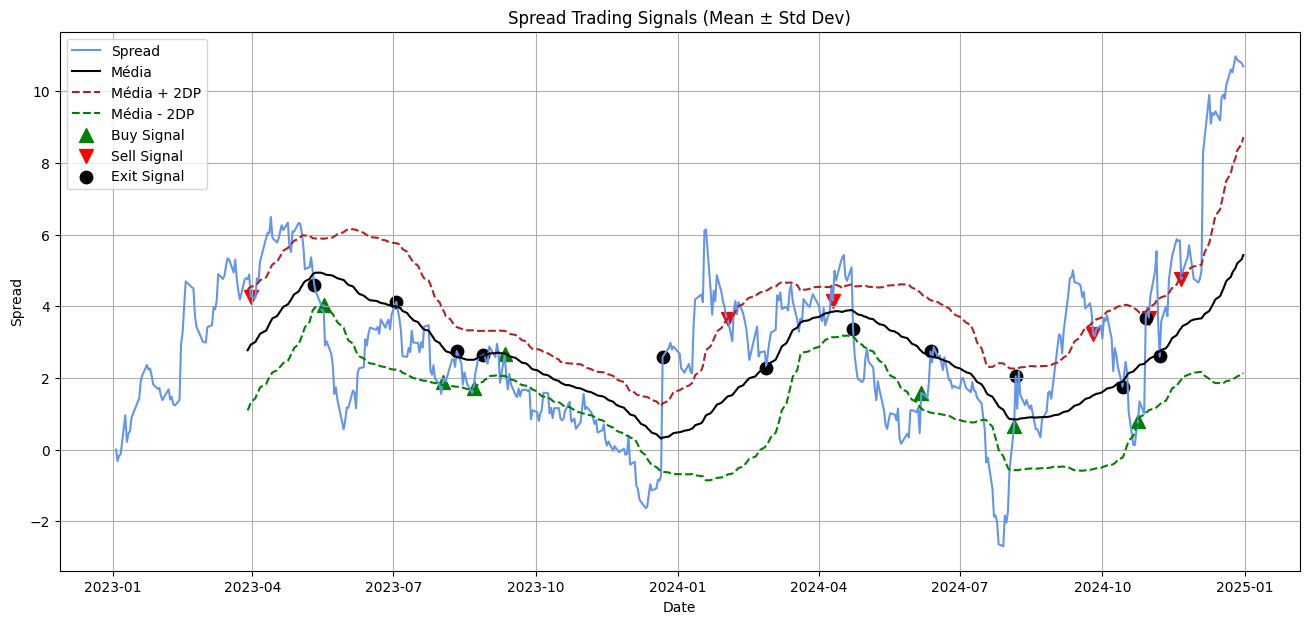

In [17]:
window_size = 60
mean_spread = spread.rolling(window=window_size).mean()
std_spread = spread.rolling(window=window_size).std()

upper_band = mean_spread + std_spread
lower_band = mean_spread - std_spread

signals = pd.DataFrame(index=spread.index)
signals['spread'] = spread
signals['long'] = False
signals['short'] = False
signals['exit'] = False

position = 0  # 0 = no position, 1 = Long, -1 = Short

for i in range(1, len(spread)):
    if position == 0:  # no position
        if spread.iloc[i-1] > upper_band.iloc[i-1] and spread.iloc[i] <= upper_band.iloc[i]:
            signals.at[spread.index[i], 'short'] = True
            position = -1  # short (short CDNS, long SNPS)
        elif spread.iloc[i-1] < lower_band.iloc[i-1] and spread.iloc[i] >= lower_band.iloc[i]:
            signals.at[spread.index[i], 'long'] = True
            position = 1  # long (long CDNS, short SNPS)
    
    elif position == 1:  # if long, saímos na média
        if spread.iloc[i-1] < mean_spread.iloc[i-1] and spread.iloc[i] >= mean_spread.iloc[i]:
            signals.at[spread.index[i], 'exit'] = True
            position = 0  # close position
    elif position == -1:  #if short, saímos na média
        if spread.iloc[i-1] > mean_spread.iloc[i-1] and spread.iloc[i] <= mean_spread.iloc[i]:
            signals.at[spread.index[i], 'exit'] = True
            position = 0  # close position

# Plot
plt.figure(figsize=(16, 7))
plt.plot(spread, label="Spread", color="cornflowerblue")
plt.plot(mean_spread, color="black", linestyle="solid", label="Média")
plt.plot(upper_band, color="firebrick", linestyle="dashed", label="Média + 2DP")
plt.plot(lower_band, color="green", linestyle="dashed", label="Média - 2DP")

# signals in the plot
plt.scatter(signals.index[signals['long']], signals['spread'][signals['long']], 
            marker="^", color="green", label="Buy Signal", s=100)
plt.scatter(signals.index[signals['short']], signals['spread'][signals['short']], 
            marker="v", color="red", label="Sell Signal", s=100)
plt.scatter(signals.index[signals['exit']], signals['spread'][signals['exit']], 
            marker="o", color="black", label="Exit Signal", s=80)

plt.legend()
plt.title("Spread Trading Signals (Mean ± Std Dev)")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.grid(True)
plt.show()


In [18]:
#160$ * 15 = 2400$ CDNS
#320$ * 7.5 = 2400$ SNPS
#Total margin = 4800$
#Initial capital = 7000$
#Capital remaining = 2200$  --> ~ 30% of the initial capital --> leave a margin for emergencies 

# User-defined contract size
num_contracts_cdns = 15  # User chooses how many CDNS contracts to trade
num_contracts_snps = num_contracts_cdns / 2  # Maintain 2:1 ratio


# Backtesting Simulation
capital = 7000  # Initial capital
position = 0
entry_price_cdns = 0
entry_price_snps = 0

for i in range(window_size, len(data)):
    date = data.index[i]
    
    if signals.at[date, 'long'] and position == 0:
        # Buy user-defined units of CDNS and SNPS
        entry_price_cdns = data.at[date, 'CDNS']
        entry_price_snps = data.at[date, 'SNPS']

        position = 1  # Enter long position
        print(f"--> {date} | Long {num_contracts_cdns}x CDNS at {entry_price_cdns:.2f}, Short {num_contracts_snps}x SNPS at {entry_price_snps:.2f}")

    elif signals.at[date, 'short'] and position == 0:
        # Short user-defined units of CDNS and SNPS
        entry_price_cdns = data.at[date, 'CDNS']
        entry_price_snps = data.at[date, 'SNPS']

        position = -1  # Enter short position
        print(f"--> {date} | Short {num_contracts_cdns}x CDNS at {entry_price_cdns:.2f}, Short {num_contracts_snps}x SNPS at {entry_price_snps:.2f}")

    elif signals.at[date, 'exit'] and position != 0:
        # Close the position
        exit_price_cdns = data.at[date, 'CDNS']
        exit_price_snps = data.at[date, 'SNPS']

        if position == 1:  # Closing a long position
            profit_cdns = (exit_price_cdns - entry_price_cdns) * num_contracts_cdns
            profit_snps = (entry_price_snps - exit_price_snps) * num_contracts_snps  # SNPS is shorted
            profit = profit_cdns + profit_snps
        else:  # Closing a short position
            profit_cdns = (entry_price_cdns - exit_price_cdns) * num_contracts_cdns  # CDNS was shorted
            profit_snps = (exit_price_snps - entry_price_snps) * num_contracts_snps
            profit = profit_cdns + profit_snps

        capital += profit  # Update capital after trade
        print(f">>> {date} | Closing position: {profit:.2f} | Capital: {capital:.2f}")
        position = 0  # Reset position

print(f"\nFinal Capital: {capital:.2f}")


--> 2023-03-31 00:00:00 | Short 15x CDNS at 210.09, Short 7.5x SNPS at 386.25
>>> 2023-05-11 00:00:00 | Closing position: -7.73 | Capital: 6992.27
--> 2023-05-17 00:00:00 | Long 15x CDNS at 204.15, Short 7.5x SNPS at 377.08
>>> 2023-07-03 00:00:00 | Closing position: 41.77 | Capital: 7034.05
--> 2023-08-02 00:00:00 | Long 15x CDNS at 228.74, Short 7.5x SNPS at 441.18
>>> 2023-08-11 00:00:00 | Closing position: 55.35 | Capital: 7089.40
--> 2023-08-22 00:00:00 | Long 15x CDNS at 225.51, Short 7.5x SNPS at 436.39
>>> 2023-08-28 00:00:00 | Closing position: 65.93 | Capital: 7155.32
--> 2023-09-11 00:00:00 | Long 15x CDNS at 243.24, Short 7.5x SNPS at 461.82
>>> 2023-12-22 00:00:00 | Closing position: 18.90 | Capital: 7174.22
--> 2024-02-02 00:00:00 | Short 15x CDNS at 296.55, Short 7.5x SNPS at 552.05
>>> 2024-02-27 00:00:00 | Closing position: 112.72 | Capital: 7286.95
--> 2024-04-10 00:00:00 | Short 15x CDNS at 304.59, Short 7.5x SNPS at 561.23
>>> 2024-04-23 00:00:00 | Closing position:

Another strategy
---

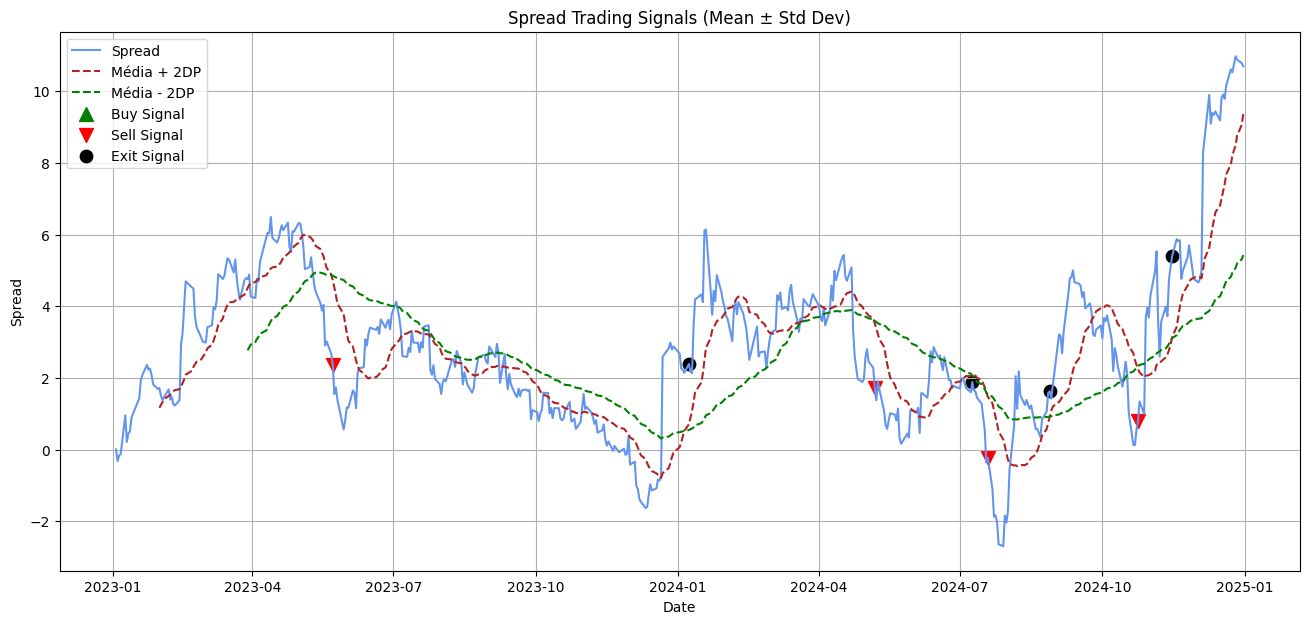

In [19]:
# Compute moving averages
short_window = 20
long_window = 60
#short_window = 10
#long_window = 30

data['MA_Short'] = data['Spread'].rolling(window=short_window).mean()
data['MA_Long'] = data['Spread'].rolling(window=long_window).mean()

# Create a signals DataFrame
signals = pd.DataFrame(index=data.index)
signals['spread'] = data['Spread']
signals['long'] = False  # Signal to go long (buy CDNS, short SNPS)
signals['short'] = False  # Signal to go short (sell CDNS, short SNPS)
signals['exit'] = False  # Signal to exit position
position = 0  # 0 = No position, 1 = Long, -1 = Short

# Generate trading signals based on moving averages
for i in range(long_window, len(data)):  # Start only after long moving average is available
    if position == 0:  # No open position
        if data['MA_Short'].iloc[i-1] < data['MA_Long'].iloc[i-1] and data['MA_Short'].iloc[i] >= data['MA_Long'].iloc[i]:
            signals.at[data.index[i], 'long'] = True
            position = 1  # Enter long position
        elif data['MA_Short'].iloc[i-1] > data['MA_Long'].iloc[i-1] and data['MA_Short'].iloc[i] <= data['MA_Long'].iloc[i]:
            signals.at[data.index[i], 'short'] = True
            position = -1  # Enter short position
    
    elif position == 1:  # If long, exit when moving averages cross again
        if data['MA_Short'].iloc[i-1] > data['MA_Long'].iloc[i-1] and data['MA_Short'].iloc[i] <= data['MA_Long'].iloc[i]:
            signals.at[data.index[i], 'exit'] = True
            position = 0  # Close position

    elif position == -1:  # If short, exit when moving averages cross again
        if data['MA_Short'].iloc[i-1] < data['MA_Long'].iloc[i-1] and data['MA_Short'].iloc[i] >= data['MA_Long'].iloc[i]:
            signals.at[data.index[i], 'exit'] = True
            position = 0  # Close position

# Plotar os resultados
plt.figure(figsize=(16, 7))
plt.plot(spread, label="Spread", color="cornflowerblue")
plt.plot(data['MA_Short'], color="firebrick", linestyle="dashed", label="Média + 2DP")
plt.plot(data['MA_Long'], color="green", linestyle="dashed", label="Média - 2DP")

# Adicionar sinais de entrada e saída
plt.scatter(signals.index[signals['long']], signals['spread'][signals['long']], 
            marker="^", color="green", label="Buy Signal", s=100)
plt.scatter(signals.index[signals['short']], signals['spread'][signals['short']], 
            marker="v", color="red", label="Sell Signal", s=100)
plt.scatter(signals.index[signals['exit']], signals['spread'][signals['exit']], 
            marker="o", color="black", label="Exit Signal", s=80)

plt.legend()
plt.title("Spread Trading Signals (Mean ± Std Dev)")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.grid(True)
plt.show()



In [20]:
#160$ * 15 = 2400$ CDNS
#320$ * 7.5 = 2400$ SNPS
#Total margin = 4800$
#Initial capital = 7000$
#Capital remaining = 2200$  --> ~ 30% of the initial capital --> leave a margin for emergencies 

num_contracts_cdns = 15  # User chooses how many CDNS contracts to trade
num_contracts_snps = num_contracts_cdns / 2  # Maintain 2:1 ratio


# Backtesting Simulation
capital = 7000  # Initial capital
position = 0
entry_price_cdns = 0
entry_price_snps = 0

for i in range(long_window, len(data)):
    date = data.index[i]
    
    if signals.at[date, 'long'] and position == 0:
        # Buy user-defined units of CDNS and SNPS
        entry_price_cdns = data.at[date, 'CDNS']
        entry_price_snps = data.at[date, 'SNPS']

        position = 1  # Enter long position
        print(f"--> {date} | Long {num_contracts_cdns}x CDNS at {entry_price_cdns:.2f}, Short {num_contracts_snps}x SNPS at {entry_price_snps:.2f}")

    elif signals.at[date, 'short'] and position == 0:
        # Short user-defined units of CDNS and SNPS
        entry_price_cdns = data.at[date, 'CDNS']
        entry_price_snps = data.at[date, 'SNPS']

        position = -1  # Enter short position
        print(f"--> {date} | Short {num_contracts_cdns}x CDNS at {entry_price_cdns:.2f}, Short {num_contracts_snps}x SNPS at {entry_price_snps:.2f}")

    elif signals.at[date, 'exit'] and position != 0:
        # Close the position
        exit_price_cdns = data.at[date, 'CDNS']
        exit_price_snps = data.at[date, 'SNPS']

        if position == 1:  # Closing a long position
            profit_cdns = (exit_price_cdns - entry_price_cdns) * num_contracts_cdns
            profit_snps = (entry_price_snps - exit_price_snps) * num_contracts_snps  # SNPS is shorted
            profit = profit_cdns + profit_snps
        else:  # Closing a short position
            profit_cdns = (entry_price_cdns - exit_price_cdns) * num_contracts_cdns  # CDNS was shorted
            profit_snps = (exit_price_snps - entry_price_snps) * num_contracts_snps
            profit = profit_cdns + profit_snps

        capital += profit  # Update capital after trade
        print(f">>> {date} | Closing position: {profit:.2f} | Capital: {capital:.2f}")
        position = 0  # Reset position

print(f"\nFinal Capital: {capital:.2f}")


--> 2023-05-23 00:00:00 | Short 15x CDNS at 205.76, Short 7.5x SNPS at 393.09
>>> 2024-01-08 00:00:00 | Closing position: -40.58 | Capital: 6959.42
--> 2024-05-07 00:00:00 | Short 15x CDNS at 284.04, Short 7.5x SNPS at 549.61
>>> 2024-07-09 00:00:00 | Closing position: -30.82 | Capital: 6928.60
--> 2024-07-19 00:00:00 | Short 15x CDNS at 279.95, Short 7.5x SNPS at 563.12
>>> 2024-08-28 00:00:00 | Closing position: -145.65 | Capital: 6782.95
--> 2024-10-24 00:00:00 | Short 15x CDNS at 251.28, Short 7.5x SNPS at 495.25
>>> 2024-11-15 00:00:00 | Closing position: -385.20 | Capital: 6397.75

Final Capital: 6397.75
